#1. Импорт и анализ таблиц

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df_data = pd.read_excel('Новый диплом датасет.xlsx', sheet_name='Данные')
df_clients = pd.read_excel('Новый диплом датасет.xlsx', sheet_name='Clients')
df_region = pd.read_excel('Новый диплом датасет.xlsx', sheet_name='Region_dict')

In [3]:
df_clients.dropna(inplace=True)
df_clients.isnull().sum()

id_client           0
dtime_ad            0
nflag_test          0
id_trading_point    0
dtype: int64

In [4]:
df_data.dropna(inplace=True) 

In [5]:
df_clients.shape

(55356, 4)

In [6]:
df_region.head()

,id_trading_point,city
0,1,Петрозаводск
1,2,Дмитров
2,4,Чехов
3,7,Ростов Великий
4,11,Владимир


In [7]:
df_data.head()

,id_order,id_client,amt_payment,dtime_pay
0,100238,194569.0,5373.0,2022-10-28 04:05:15.221
1,100242,191056.0,4151.0,2022-08-01 02:42:54.992
2,100249,200049.0,5688.0,2022-08-24 12:45:12.744
3,100258,206161.0,4330.0,2022-12-09 15:13:26.437
4,100267,190945.0,5488.0,2022-08-03 02:07:31.468


In [8]:
city_cnt = df_region.groupby(['city']).agg(point_cnt = ('id_trading_point', 'count')).reset_index()\
                                                                                    .sort_values('point_cnt', ascending = False)
city_cnt.head()

,city,point_cnt
7,Москва,11
15,Санкт-Петербург,11
4,Казань,6
10,Новосибирск,6
6,Красноярск,5


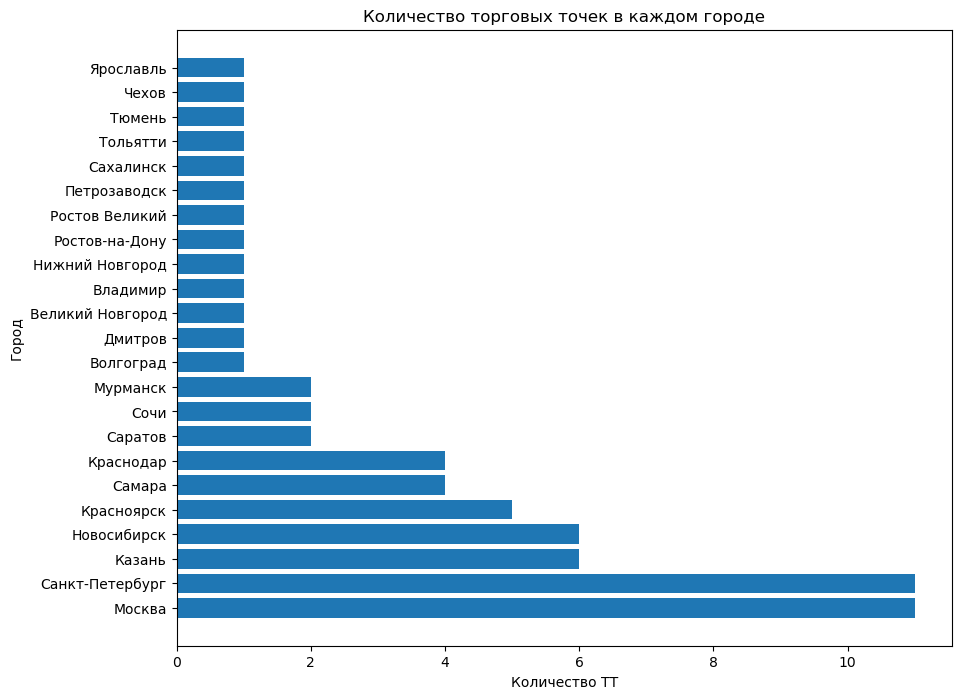

In [9]:
plt.figure(figsize=(10, 8))
plt.barh(city_cnt['city'], city_cnt['point_cnt'])
plt.title('Количество торговых точек в каждом городе')
plt.xlabel('Количество ТТ')
plt.ylabel('Город')
plt.show()

#2. Объединение таблиц

In [10]:
df_sum_pay = df_data.groupby(['id_client']).agg(sum_pay = ('amt_payment', 'sum')).reset_index()
df_sum_pay

,id_client,sum_pay
0,178561.0,3052.0
1,178562.0,2439.0
2,178563.0,768.0
3,178565.0,958.0
4,178566.0,5474.0
...,...,...
28378,209630.0,6927.0
28379,209631.0,2090.0
28380,209632.0,2775.0
28381,209633.0,1673.0


In [11]:
df_pay_all = df_sum_pay.merge(df_clients, on = 'id_client', how = 'right')
df_pay_all.head()

,id_client,sum_pay,dtime_ad,nflag_test,id_trading_point
0,180844.0,5349.0,2022-06-08 18:38:41.414,0,212
1,226069.0,NaN,2022-07-11 16:28:38.511,1,54
2,183981.0,6322.0,2022-06-16 12:23:59.289,1,991
3,322530.0,NaN,2022-07-08 08:56:08.714,0,1015
4,254313.0,NaN,2022-06-19 22:18:01.770,1,453


In [12]:
df_pay_all.loc[df_pay_all['sum_pay'].isnull(), 'sum_pay'] = 0
df_pay_all.isnull().sum()

id_client           0
sum_pay             0
dtime_ad            0
nflag_test          0
id_trading_point    0
dtype: int64

In [13]:
df_pay_all = df_pay_all.merge(df_region, on = 'id_trading_point', how = 'inner')
df_pay_all.shape

(55356, 6)

In [14]:
df_pay_all['flag_pay'] = 0
df_pay_all.loc[df_pay_all['sum_pay'] > 0, 'flag_pay'] = 1

In [15]:
df_pay_all.shape

(55356, 7)

#3. Автоматизация статистических вычислений

In [16]:
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu

In [17]:
def test_calc(r1, r2, alpha=0.05):
    s, p = ttest_ind(r1, r2)
    print('Pазница между средними значениями:', r1.mean()-r2.mean())
    if p < alpha:
        print('Гипотеза отвергается, разница стат. значима')
    else:
        print('Гипотеза не отвергается, средние равны')
    print("p-value = ", p)

In [18]:
test_calc(df_pay_all[df_pay_all['nflag_test']==1]['sum_pay'], df_pay_all[df_pay_all['nflag_test']==0]['sum_pay'])

Pазница между средними значениями: 159.60107512668037
Гипотеза отвергается, разница стат. значима
p-value =  1.5624051059175334e-10


In [19]:
def mann_whitney_func(r1, r2, alpha=0.05):
    s, p = mannwhitneyu(r1, r2)
    print('Pазница между средними значениями:', r1.mean()-r2.mean())
    if p < alpha:
        print('Гипотеза отвергается, разница стат. значима')
    else:
        print('Гипотеза не отвергается, средние равны')
    print("p-value = ", p)

In [20]:
mann_whitney_func(df_pay_all[df_pay_all['nflag_test']==1]['sum_pay'], df_pay_all[df_pay_all['nflag_test']==0]['sum_pay'])

Pазница между средними значениями: 159.60107512668037
Гипотеза отвергается, разница стат. значима
p-value =  5.082016727027916e-10


#4. Чистка неверно заполненных точек

In [21]:
zero_payment_points = []

for i in df_pay_all['id_trading_point'].unique():

    df_loc = df_pay_all[df_pay_all['id_trading_point']==i]
    sum_a = df_pay_all[(df_pay_all['id_trading_point'] == i) & (df_pay_all['nflag_test'] == 0)]['sum_pay'].sum()
    sum_b = df_pay_all[(df_pay_all['id_trading_point'] == i) & (df_pay_all['nflag_test'] == 1)]['sum_pay'].sum()
    if (sum_a == 0) | (sum_b == 0):
        zero_payment_points.append(i)
print(zero_payment_points)

[np.int64(1015), np.int64(866), np.int64(1099), np.int64(739), np.int64(46), np.int64(228), np.int64(26), np.int64(603), np.int64(810), np.int64(800), np.int64(7), np.int64(23), np.int64(4), np.int64(1), np.int64(13)]


In [22]:
empty_group_points = []

for i in df_pay_all['id_trading_point'].unique():
 
    c_control = df_pay_all[(df_pay_all['id_trading_point'] == i) & (df_pay_all['nflag_test'] == 0)]['id_client'].count()
    c_test = df_pay_all[(df_pay_all['id_trading_point'] == i) & (df_pay_all['nflag_test'] == 1)]['id_client'].count()
    if (c_control == 0) | (c_test == 0):
        empty_group_points.append(i)
print(empty_group_points)

[np.int64(1015), np.int64(866), np.int64(1099), np.int64(739), np.int64(228), np.int64(603), np.int64(810), np.int64(800)]


#5. Расчет общих результатов A/B-теста

In [23]:
df_pay_all_1 = df_pay_all[~df_pay_all['id_trading_point'].isin(zero_payment_points + empty_group_points)]
df_pay_all_1.head()

,id_client,sum_pay,dtime_ad,nflag_test,id_trading_point,city,flag_pay
0,180844.0,5349.0,2022-06-08 18:38:41.414,0,212,Красноярск,1
1,226069.0,0.0,2022-07-11 16:28:38.511,1,54,Мурманск,0
2,183981.0,6322.0,2022-06-16 12:23:59.289,1,991,Казань,1
4,254313.0,0.0,2022-06-19 22:18:01.770,1,453,Санкт-Петербург,0
5,195818.0,4021.0,2022-07-16 01:30:59.088,1,2652,Москва,1


In [24]:
df_pay_all_1.shape

(45318, 7)

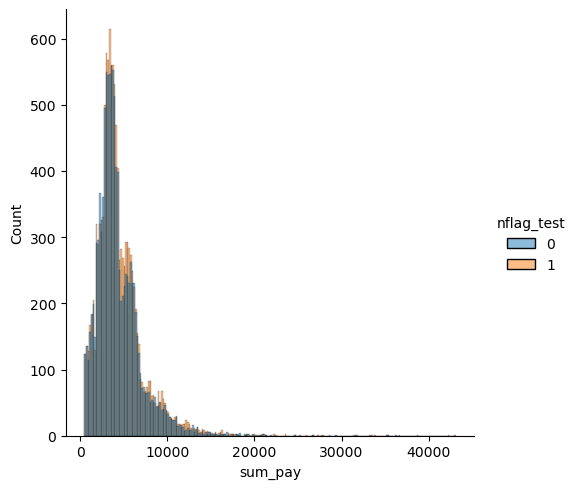

In [25]:
sns.displot(df_pay_all_1[df_pay_all_1['sum_pay']>0], x='sum_pay', hue='nflag_test')
plt.show ()

In [26]:
test_calc(df_pay_all_1[df_pay_all_1['nflag_test']==1]['sum_pay'], df_pay_all_1[df_pay_all_1['nflag_test']==0]['sum_pay'])

Pазница между средними значениями: 263.088912844727
Гипотеза отвергается, разница стат. значима
p-value =  3.3214645838934018e-21


In [27]:
test_calc(df_pay_all_1[df_pay_all_1['nflag_test']==1]['flag_pay'], df_pay_all_1[df_pay_all_1['nflag_test']==0]['flag_pay'])

Pазница между средними значениями: 0.043524040271688325
Гипотеза отвергается, разница стат. значима
p-value =  1.7338073027564523e-20


In [28]:
mann_whitney_func(df_pay_all_1[df_pay_all_1['nflag_test']==1]['sum_pay'], df_pay_all_1[df_pay_all_1['nflag_test']==0]['sum_pay'])

Pазница между средними значениями: 263.088912844727
Гипотеза отвергается, разница стат. значима
p-value =  3.008345273971901e-24


#6. Сегментация результатов A/B-теста

In [29]:
df_mosc_sum_0 = df_pay_all_1[(df_pay_all_1['city'] == 'Москва') & (df_pay_all_1['nflag_test']==0)]['sum_pay']
df_mosc_sum_1 = df_pay_all_1[(df_pay_all_1['city'] == 'Москва') & (df_pay_all_1['nflag_test']==1)]['sum_pay']
test_calc(df_mosc_sum_0, df_mosc_sum_1)

Pазница между средними значениями: -381.7784892750842
Гипотеза отвергается, разница стат. значима
p-value =  1.757549439555765e-14


In [30]:
df_mosc_conv_0 = df_pay_all_1[(df_pay_all_1['city'] == 'Москва') & (df_pay_all_1['nflag_test']==0)]['flag_pay']
df_mosc_conv_1 = df_pay_all_1[(df_pay_all_1['city'] == 'Москва') & (df_pay_all_1['nflag_test']==1)]['flag_pay']
test_calc(df_mosc_conv_0, df_mosc_conv_1)

Pазница между средними значениями: -0.05557800593933432
Гипотеза отвергается, разница стат. значима
p-value =  6.194689260032594e-10


In [31]:
df_pits_sum_0 = df_pay_all_1[(df_pay_all_1['city'] == 'Санкт-Петербург') & (df_pay_all_1['nflag_test']==0)]['sum_pay']
df_pits_sum_1 = df_pay_all_1[(df_pay_all_1['city'] == 'Санкт-Петербург') & (df_pay_all_1['nflag_test']==1)]['sum_pay']
test_calc(df_pits_sum_0, df_pits_sum_1)

Pазница между средними значениями: -513.9039043833998
Гипотеза отвергается, разница стат. значима
p-value =  2.3198088937974163e-18


In [32]:
df_pits_conv_0 = df_pay_all_1[(df_pay_all_1['city'] == 'Санкт-Петербург') & (df_pay_all_1['nflag_test']==0)]['flag_pay']
df_pits_conv_1 = df_pay_all_1[(df_pay_all_1['city'] == 'Санкт-Петербург') & (df_pay_all_1['nflag_test']==1)]['flag_pay']
test_calc(df_pits_conv_0, df_pits_conv_1)

Pазница между средними значениями: -0.09877797751600403
Гипотеза отвергается, разница стат. значима
p-value =  1.065825659919673e-20


In [33]:
city_other = df_pay_all_1[(df_pay_all_1['city']!= 'Санкт-Петербург') & (df_pay_all_1['city']!= 'Москва')]
city_other.head()

,id_client,sum_pay,dtime_ad,nflag_test,id_trading_point,city,flag_pay
0,180844.0,5349.0,2022-06-08 18:38:41.414,0,212,Красноярск,1
1,226069.0,0.0,2022-07-11 16:28:38.511,1,54,Мурманск,0
2,183981.0,6322.0,2022-06-16 12:23:59.289,1,991,Казань,1
12,212625.0,0.0,2022-08-16 14:19:05.040,0,278,Красноярск,0
14,287462.0,0.0,2022-07-13 12:13:50.168,1,699,Казань,0


Красноярск


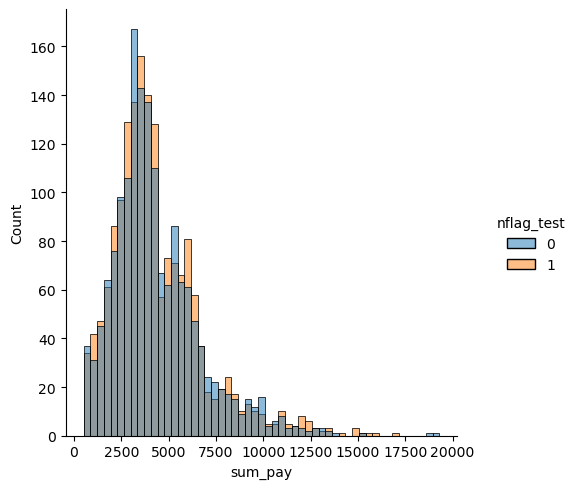

ttest sum_pay
Pазница между средними значениями: 8.718297889251062
Гипотеза не отвергается, средние равны
p-value =  0.9044823881233125
ttest_conv
Pазница между средними значениями: -0.003592020255924089
Гипотеза не отвергается, средние равны
p-value =  0.7805336501430107
mwtest_sum_pay
Pазница между средними значениями: 8.718297889251062
Гипотеза не отвергается, средние равны
p-value =  0.8770469886251647

Мурманск


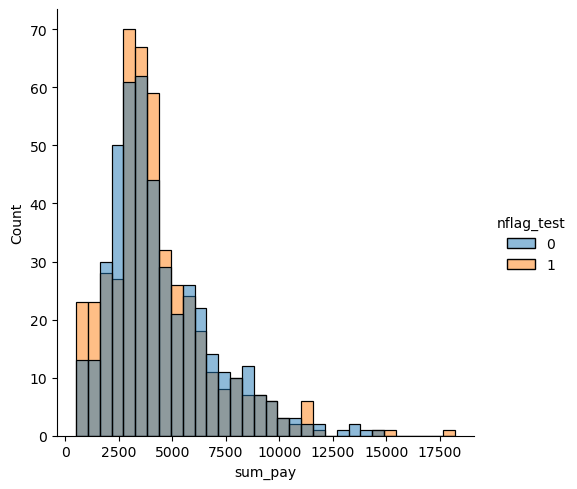

ttest sum_pay
Pазница между средними значениями: 8.051371737534055
Гипотеза не отвергается, средние равны
p-value =  0.9449762446327565
ttest_conv
Pазница между средними значениями: 0.018187481921545068
Гипотеза не отвергается, средние равны
p-value =  0.3976422846466432
mwtest_sum_pay
Pазница между средними значениями: 8.051371737534055
Гипотеза не отвергается, средние равны
p-value =  0.5434251528583327

Казань


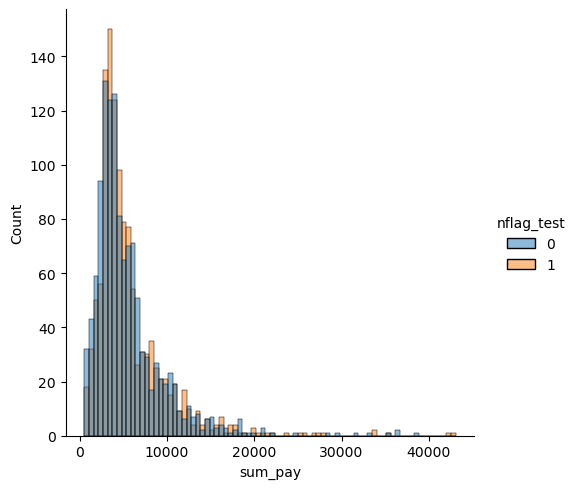

ttest sum_pay
Pазница между средними значениями: 121.22480263872694
Гипотеза не отвергается, средние равны
p-value =  0.286688049247618
ttest_conv
Pазница между средними значениями: 0.003829103608847473
Гипотеза не отвергается, средние равны
p-value =  0.784829789025573
mwtest_sum_pay
Pазница между средними значениями: 121.22480263872694
Гипотеза не отвергается, средние равны
p-value =  0.37726004167062477

Саратов


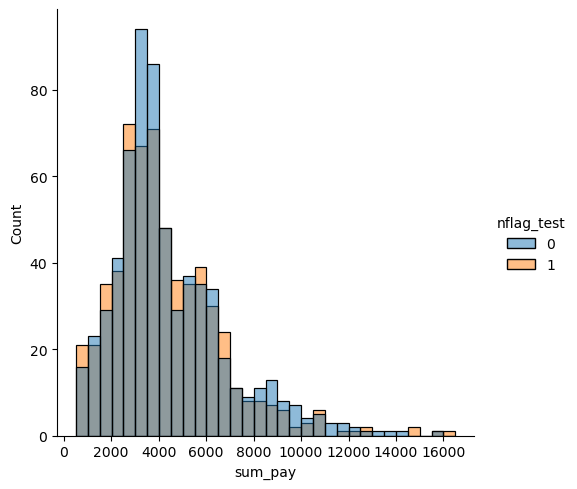

ttest sum_pay
Pазница между средними значениями: -12.85688039258821
Гипотеза не отвергается, средние равны
p-value =  0.9162512798549167
ttest_conv
Pазница между средними значениями: 0.013960087839155033
Гипотеза не отвергается, средние равны
p-value =  0.5152558091282406
mwtest_sum_pay
Pазница между средними значениями: -12.85688039258821
Гипотеза не отвергается, средние равны
p-value =  0.7833257779753139

Тольятти


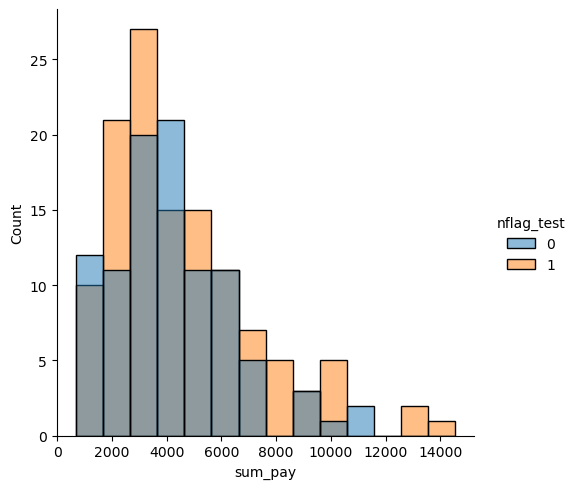

ttest sum_pay
Pазница между средними значениями: 462.9494484714778
Гипотеза не отвергается, средние равны
p-value =  0.1333273246710206
ttest_conv
Pазница между средними значениями: 0.061266939804601295
Гипотеза не отвергается, средние равны
p-value =  0.23675311799785542
mwtest_sum_pay
Pазница между средними значениями: 462.9494484714778
Гипотеза не отвергается, средние равны
p-value =  0.22134177144014489

Тюмень


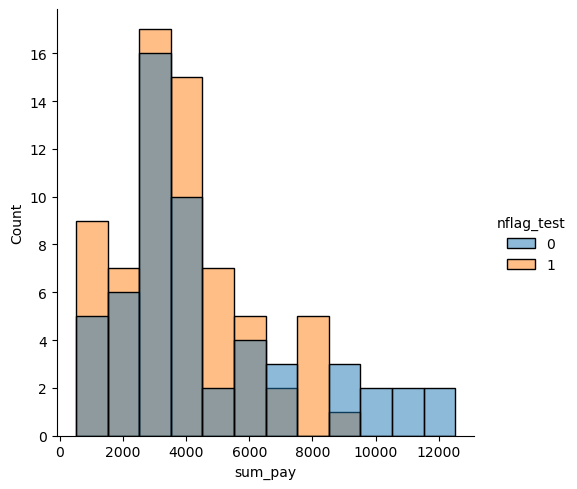

ttest sum_pay
Pазница между средними значениями: 300.4463645943099
Гипотеза не отвергается, средние равны
p-value =  0.3550227648604757
ttest_conv
Pазница между средними значениями: 0.1463645943097998
Гипотеза отвергается, разница стат. значима
p-value =  0.01451825932213329
mwtest_sum_pay
Pазница между средними значениями: 300.4463645943099
Гипотеза отвергается, разница стат. значима
p-value =  0.038066216007540725

Волгоград


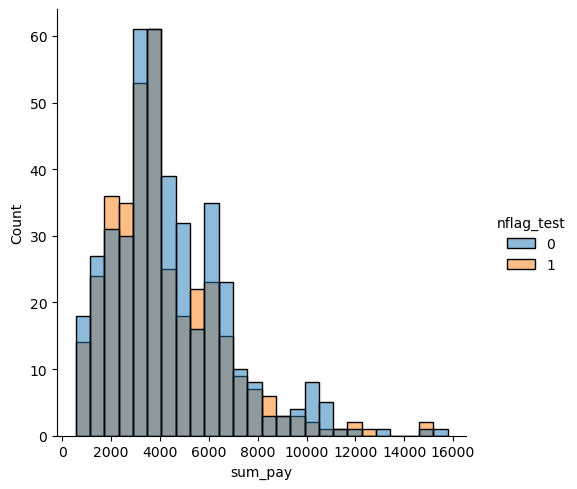

ttest sum_pay
Pазница между средними значениями: -312.89040013337035
Гипотеза отвергается, разница стат. значима
p-value =  0.03686899928098654
ttest_conv
Pазница между средними значениями: -0.04350565417616603
Гипотеза не отвергается, средние равны
p-value =  0.10498894497258296
mwtest_sum_pay
Pазница между средними значениями: -312.89040013337035
Гипотеза отвергается, разница стат. значима
p-value =  0.03323940159324537

Сочи


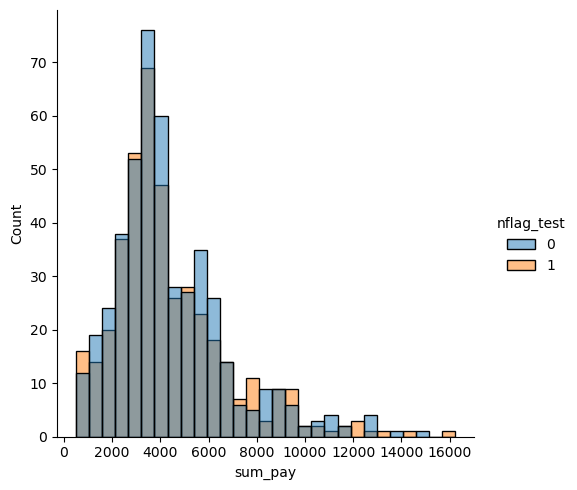

ttest sum_pay
Pазница между средними значениями: -217.2514838460288
Гипотеза не отвергается, средние равны
p-value =  0.12297605685687812
ttest_conv
Pазница между средними значениями: -0.04931605920420967
Гипотеза отвергается, разница стат. значима
p-value =  0.047319885252583245
mwtest_sum_pay
Pазница между средними значениями: -217.2514838460288
Гипотеза не отвергается, средние равны
p-value =  0.05698257474271896

Владимир


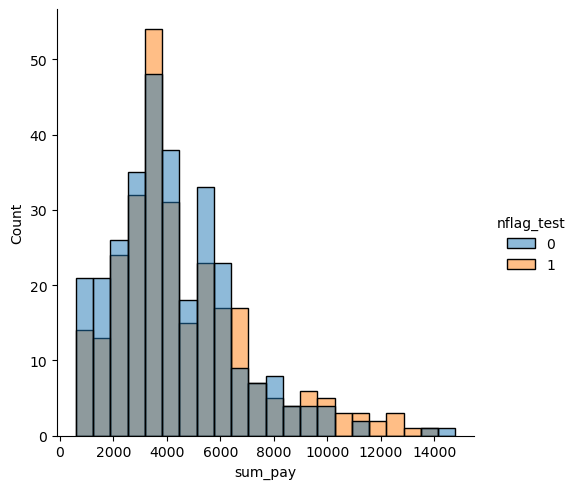

ttest sum_pay
Pазница между средними значениями: 438.6098419243094
Гипотеза отвергается, разница стат. значима
p-value =  0.010095112170351712
ttest_conv
Pазница между средними значениями: 0.05174296866921729
Гипотеза не отвергается, средние равны
p-value =  0.08481593543159477
mwtest_sum_pay
Pазница между средними значениями: 438.6098419243094
Гипотеза отвергается, разница стат. значима
p-value =  0.03166761411886426

Самара


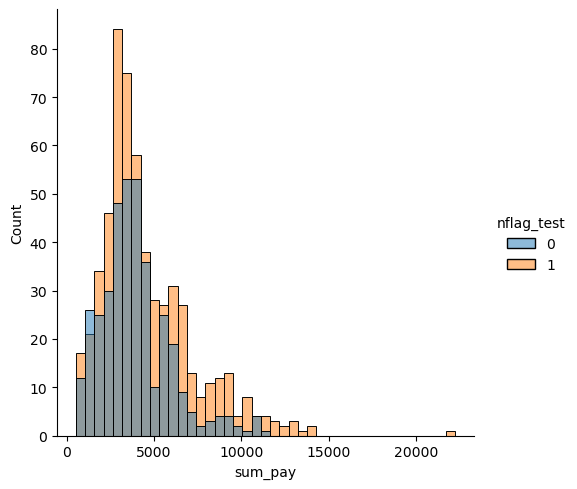

ttest sum_pay
Pазница между средними значениями: 1544.3720191247648
Гипотеза отвергается, разница стат. значима
p-value =  1.1014020778472052e-29
ttest_conv
Pазница между средними значениями: 0.2772412939282998
Гипотеза отвергается, разница стат. значима
p-value =  3.981449742682522e-31
mwtest_sum_pay
Pазница между средними значениями: 1544.3720191247648
Гипотеза отвергается, разница стат. значима
p-value =  4.325201867794148e-30

Краснодар


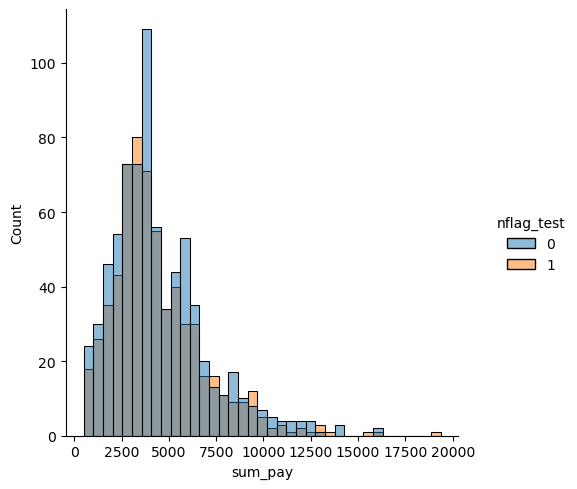

ttest sum_pay
Pазница между средними значениями: -215.62639239464443
Гипотеза не отвергается, средние равны
p-value =  0.085800112916198
ttest_conv
Pазница между средними значениями: -0.03894675290825289
Гипотеза не отвергается, средние равны
p-value =  0.06038527567849974
mwtest_sum_pay
Pазница между средними значениями: -215.62639239464443
Гипотеза не отвергается, средние равны
p-value =  0.05938101983441801

Сахалинск


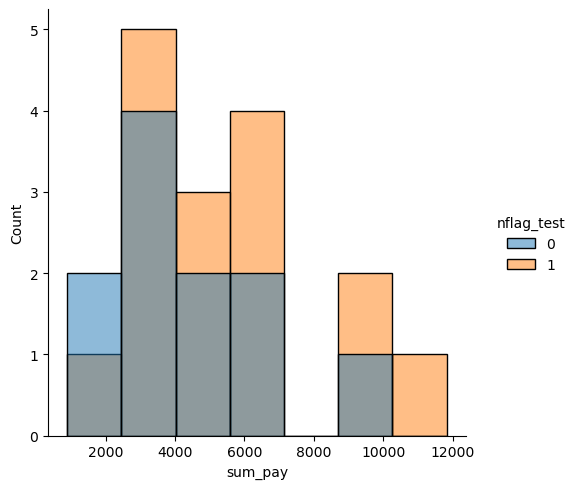

ttest sum_pay
Pазница между средними значениями: 571.2994871794872
Гипотеза не отвергается, средние равны
p-value =  0.105809212549273
ttest_conv
Pазница между средними значениями: 0.07230769230769232
Гипотеза не отвергается, средние равны
p-value =  0.24367247406936435
mwtest_sum_pay
Pазница между средними значениями: 571.2994871794872
Гипотеза не отвергается, средние равны
p-value =  0.19868569514015844

Дмитров


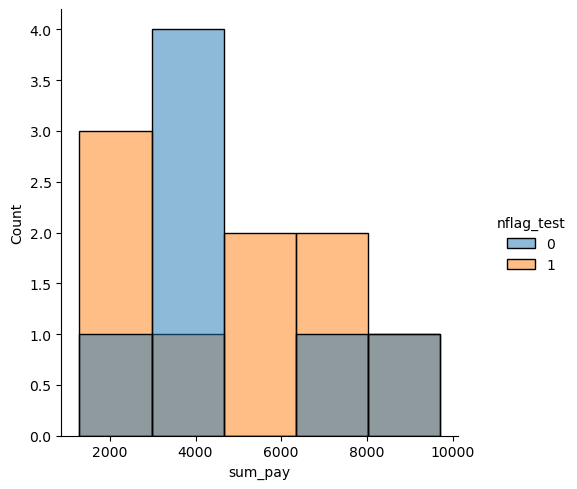

ttest sum_pay
Pазница между средними значениями: 95.88262910798124
Гипотеза не отвергается, средние равны
p-value =  0.7410763125801646
ttest_conv
Pазница между средними значениями: 0.01679306608884075
Гипотеза не отвергается, средние равны
p-value =  0.7429421277261776
mwtest_sum_pay
Pазница между средними значениями: 95.88262910798124
Гипотеза не отвергается, средние равны
p-value =  0.7422551789442879



In [34]:
for i in city_other['city'].unique():
    print(i)
    city_test = df_pay_all_1[(df_pay_all_1['city']==i)]
    
    sns.displot(city_test[city_test['sum_pay']>0], x='sum_pay', hue='nflag_test')
    plt.show ()
    
    print('ttest sum_pay')
    test_calc(city_test[city_test['nflag_test']==1]['sum_pay'], city_test[city_test['nflag_test']==0]['sum_pay'])
    print('ttest_conv')
    test_calc(city_test[city_test['nflag_test']==1]['flag_pay'], city_test[city_test['nflag_test']==0]['flag_pay'])
    print('mwtest_sum_pay')
    mann_whitney_func(city_test[city_test['nflag_test']==1]['sum_pay'], city_test[city_test['nflag_test']==0]['sum_pay'])
    print()

#7. Отчет по A/B-тесту

NameError: name 'count_all' is not defined

In [43]:
df_result = pd.DataFrame()
for i in df_pay_all_1['city'].unique():
    print(i)
    df_loc = df_pay_all_1[df_pay_all_1['city'] == i]
    for j in df_loc['id_trading_point'].unique():
        print(j)
        df_loc_f = df_loc[df_loc['id_trading_point'] == j]

        count_test    = len(df_loc_f[df_loc_f['nflag_test'] == 1])
        count_control = len(df_loc_f[df_loc_f['nflag_test'] == 0])
        count_all     = count_test + count_control

        sigma_test    = df_loc_f[df_loc_f['nflag_test'] == 1]['sum_pay'].std()
        sigma_control = df_loc_f[df_loc_f['nflag_test'] == 0]['sum_pay'].std()

        avg_test      = np.mean(df_loc_f[df_loc_f['nflag_test'] == 1]['sum_pay'])
        avg_control   = np.mean(df_loc_f[df_loc_f['nflag_test'] == 0]['sum_pay'])

        diff          = avg_test - avg_control

        t_stat, p_value = (0, 1)  
        if count_test > 1 and count_control > 1:  
            t_stat, p_value = ttest_ind(
                df_loc_f[df_loc_f['nflag_test'] == 1]['sum_pay'],
                df_loc_f[df_loc_f['nflag_test'] == 0]['sum_pay'],
                equal_var=False)

        if p_value < 0.05:  # Уровень значимости
            if diff > 0:
                outcome_label = 'Положительный исход'
            elif diff < 0:
                outcome_label = 'Отрицательный исход'
        else:
            outcome_label = 'Нейтральный исход' 

## создаем промежуточный датафрейм

        df_new = pd.DataFrame([{'city':i
                         , 'id_trading_point':j
                         , 'count_test':count_test
                         , 'count_control':count_control
                         , 'count_all':count_all    
                         , 'avg_test':avg_test
                         , 'avg_control':avg_control
                         , 'sigma_test':sigma_test
                         , 'sigma_control':sigma_control
                         , 'diff':diff
                         , 'ttest': t_stat
                         , 'pvalue_ttest': p_value
                         , 'outcome_label': outcome_label}])
        
        df_result = pd.concat([df_result, df_new], ignore_index=True)
        df_result.head()
df_result['percent_count'] = (df_result['count_all'] / df_result['count_all'].sum())

Красноярск
212
278
202
444
277
Мурманск
54
55
Казань
991
699
477
544
516
439
Санкт-Петербург
453
112
394
801
573
576
309
900
117
213
891
Москва
2652
6543
1287
3987
8543
2212
1654
9121
9931
3786
1002
Саратов
80
82
Тольятти
88
Тюмень
19
Волгоград
66
Сочи
72
73
Владимир
11
Самара
33
34
35
36
Краснодар
1101
1989
Сахалинск
69
Дмитров
2


In [44]:
df_result.head()

,city,id_trading_point,count_test,count_control,count_all,avg_test,avg_control,sigma_test,sigma_control,diff,ttest,pvalue_ttest,outcome_label,percent_count
0,Красноярск,212,593,575,1168,2144.317032,2222.052174,2708.588724,2785.116250,-77.735142,-0.483378,0.628919,Нейтральный исход,0.025773
1,Красноярск,278,535,489,1024,2499.345794,2185.214724,2915.995329,2574.915597,314.131070,1.830426,0.067478,Нейтральный исход,0.022596
2,Красноярск,202,551,565,1116,2927.341198,2730.378761,2956.686241,2737.885785,196.962437,1.153961,0.248766,Нейтральный исход,0.024626
3,Красноярск,444,650,562,1212,2404.106154,2545.734875,2810.828487,2797.138764,-141.628722,-0.877051,0.380636,Нейтральный исход,0.026744
4,Красноярск,277,708,709,1417,2285.750000,2431.365303,2712.677878,2868.587569,-145.615303,-0.981744,0.326394,Нейтральный исход,0.031268


In [45]:
with pd.ExcelWriter('report.xlsx') as writer:
    positive_outcomes = df_result[df_result['outcome_label'] == 'Положительный исход']
    negative_outcomes = df_result[df_result['outcome_label'] == 'Отрицательный исход']
    neutral_outcomes = df_result[df_result['outcome_label'] == 'Нейтральный исход']  

    positive_outcomes.to_excel(writer, sheet_name="Positive outcomes", index=False)
    negative_outcomes.to_excel(writer, sheet_name="Negative outcomes", index=False)
    neutral_outcomes.to_excel(writer, sheet_name="Neutral outcomes", index=False)